In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import random
from cleantitanic import cleanTitanic, encodeCategories

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
df = pd.concat([train_data, test_data])
df = cleanTitanic(df)
df = df.reset_index(drop = True)
df = encodeCategories(["Sex", "Embarked", "Title", "Deck"],df)
df['Fare'] = df['Fare'].replace("Unknown", pd.to_numeric(df['Fare'], errors='coerce').mean())
df["Fare"] = df["Fare"].astype(float)
df

c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,0.0,3,22.0,1,0,7.2500,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3,26.0,0,0,7.9250,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3,35.0,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,Unknown,3,Unknown,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,Unknown,1,39.0,0,0,108.9000,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,Unknown,3,38.5,0,0,7.2500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,Unknown,3,Unknown,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
ageTrainDf = df[~(df['Age'] == 'Unknown')]
newOrder = ['Pclass', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown', 'Age']
ageTrainDf = ageTrainDf[newOrder]
ageTrainDf["Age"] = ageTrainDf["Age"].astype(float)

ageTrainDf["Age"] = ageTrainDf["Age"]/100
ageTrainDf

,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Age
0,3,1,0,7.2500,1,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.220
1,1,1,0,71.2833,1,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380
2,3,0,0,7.9250,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.260
3,1,1,0,53.1000,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350
4,3,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,3,1,1,13.7750,2,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.030
1302,1,1,0,90.0000,1,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370
1303,3,0,0,7.7750,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.280
1305,1,0,0,108.9000,0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390


In [5]:
ageUnknownDf = df[(df['Age'] == 'Unknown')]
newOrder = ['Pclass', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown']
ageUnknownDf = ageUnknownDf[newOrder]

ageUnknownDf

,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
5,3,0,0,8.4583,0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,2,0,0,13.0000,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,3,0,0,7.2250,0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,3,0,0,7.2250,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28,3,0,0,7.8792,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,3,0,0,7.7208,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1301,3,0,0,7.7500,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1304,3,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,3,0,0,8.0500,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = torch.Tensor(df.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :-1], self.data[index, -1]


In [7]:
trainDataset = CustomDataset(ageTrainDf)
validDataset = CustomDataset(ageTrainDf[850:950])
testDataset = CustomDataset(ageTrainDf[950:])
agePredictDataset = CustomDataset(ageUnknownDf)

# Create a data loader to iterate over the dataset
batch_size = 8  # Choose an appropriate batch size
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validDataset, batch_size=batch_size)
test_loader = DataLoader(testDataset, batch_size=batch_size)

c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Ivan\miniconda3\envs\TitanicKaggle\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Pleas

Epoch [1/200], MSE: 2.6294588411141557
Validation MSE: 0.03327185495828207
Epoch [2/200], MSE: 0.037688245253907585
Validation MSE: 0.02374559365069637
Epoch [3/200], MSE: 0.023959353265800436
Validation MSE: 0.02150048720292174
Epoch [4/200], MSE: 0.025061045279228734
Validation MSE: 0.026201043707820084
Epoch [5/200], MSE: 0.023116600241170814
Validation MSE: 0.02293944752846773
Epoch [6/200], MSE: 0.02750214653885888
Validation MSE: 0.03546988398123246
Epoch [7/200], MSE: 0.025334211766634505
Validation MSE: 0.037073521624104336
Epoch [8/200], MSE: 0.028411106796551296
Validation MSE: 0.03282032491495976
Epoch [9/200], MSE: 0.023192583549526014
Validation MSE: 0.02138890544525706
Epoch [10/200], MSE: 0.023823005929304898
Validation MSE: 0.02036430572087948
Epoch [11/200], MSE: 0.02435674785302227
Validation MSE: 0.021190278733579013
Epoch [12/200], MSE: 0.023930534432492864
Validation MSE: 0.02240497149670353
Epoch [13/200], MSE: 0.07362535487476538
Validation MSE: 0.020557381964933

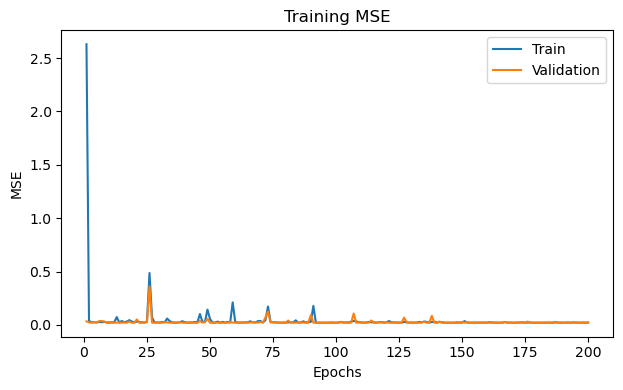

In [8]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set the device (CPU or GPU)


# Define hyperparameters
input_size = 24  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Number of output classes (yes, no)
learning_rate = 0.001
num_epochs = 200


# Create an instance of the MLP model
model = MLP(input_size, hidden_size, output_size).to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []

valid_mse_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Iterate over the training dataset
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], MSE: {average_loss}")

    train_loss_values.append(average_loss)


    # Validation loop
    model.eval()
    total_mse = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            mse = criterion(outputs, labels)
            total_mse += mse.item()

    # Calculate the accuracy on the validation set
    average_mse = total_mse / len(valid_loader)
    print(f"Validation MSE: {average_mse}")

    valid_mse_values.append(average_mse)

# Testing loop
model.eval()

total_mse = 0
# Disable gradient calculation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        mse = criterion(outputs, labels)
        total_mse += mse.item()

# Calculate the accuracy on the test set
average_mse = total_mse / len(valid_loader)
print(f"Test Accuracy: {average_mse}")


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plotting the training loss

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_values, label='Train')
plt.plot(epochs, valid_mse_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
agePredictDataset.data= agePredictDataset.data.to(device)

ages = model(agePredictDataset.data)
ages=ages.squeeze(dim=1)

agePredictedDf = df[(df['Age'] == 'Unknown')]
agePredictedDf= agePredictedDf.drop(["Age"],axis=1)
numpy_array = ages.cpu().detach().numpy()
agePredictedDf['Age'] = pd.Series(numpy_array, index=agePredictedDf.index)
newOrder = ['Survived','Pclass', 'Age','SibSp', 'Parch', 'Fare', 'FamilySize',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown']
agePredictedDf = agePredictedDf[newOrder]
agePredictedDf

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
5,0.0,3,0.300232,0,0,8.4583,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,1.0,2,0.295107,0,0,13.0000,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,1.0,3,0.299266,0,0,7.2250,0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,0.0,3,0.289067,0,0,7.2250,0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28,1.0,3,0.276359,0,0,7.8792,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,Unknown,3,0.275343,0,0,7.7208,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1301,Unknown,3,0.275530,0,0,7.7500,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1304,Unknown,3,0.286678,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,Unknown,3,0.286678,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
ageKnownDf = df[~(df['Age'] == 'Unknown')]
ageKnownDf

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,0.0,3,22.0,1,0,7.2500,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3,26.0,0,0,7.9250,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3,35.0,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,Unknown,3,3.0,1,1,13.7750,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1302,Unknown,1,37.0,1,0,90.0000,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1303,Unknown,3,28.0,0,0,7.7750,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,Unknown,1,39.0,0,0,108.9000,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df = pd.concat([ageKnownDf,agePredictedDf],axis=0)
df = df.sort_index()
newOrder = ['Pclass', 'Age','SibSp', 'Parch', 'Fare', 'FamilySize',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown', 'Survived']
df = df[newOrder]

df.head(892)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Survived
0,3,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,26.0,0,0,7.9250,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,1,19.0,0,0,30.0000,0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,3,0.274111,1,2,23.4500,3,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1,26.0,0,0,30.0000,0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
890,3,32.0,0,0,7.7500,0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
df["Age"] = df["Age"].astype(float)
train_data = df[:891]
train_data["Survived"] = train_data["Survived"].astype(float)
test_data = df[891:]
test_data = test_data.drop(["Survived"],axis=1)
train_data

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7600\1515190227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Survived"] = train_data["Survived"].astype(float)


,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Survived
0,3,22.000000,1,0,7.2500,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,38.000000,1,0,71.2833,1,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,26.000000,0,0,7.9250,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1,35.000000,1,0,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,35.000000,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
887,1,19.000000,0,0,30.0000,0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,3,0.274111,1,2,23.4500,3,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,1,26.000000,0,0,30.0000,0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Assuming you have a DataFrame called 'df' with the appropriate input and target columns

# Create an instance of the custom dataset
trainDataset = CustomDataset(train_data)
validDataset = CustomDataset(train_data[700:850])
testDataset = CustomDataset(train_data[850:])
solutionDataset = CustomDataset(test_data)

# Create a data loader to iterate over the dataset
batch_size = 8  # Choose an appropriate batch size
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validDataset, batch_size=batch_size)
test_loader = DataLoader(testDataset, batch_size=batch_size)


Training Accuracy: 0.6251402918069585
Epoch [1/200], Average Loss: 0.7856863085180521
Validation Accuracy: 0.7333333333333333
Training Accuracy: 0.7239057239057239
Epoch [2/200], Average Loss: 0.5685628596693277
Validation Accuracy: 0.78
Training Accuracy: 0.7373737373737373
Epoch [3/200], Average Loss: 0.528341479865568
Validation Accuracy: 0.7866666666666666
Training Accuracy: 0.7676767676767676
Epoch [4/200], Average Loss: 0.5039743497701628
Validation Accuracy: 0.78
Training Accuracy: 0.7822671156004489
Epoch [5/200], Average Loss: 0.4877962600439787
Validation Accuracy: 0.8066666666666666
Training Accuracy: 0.7833894500561167
Epoch [6/200], Average Loss: 0.47453274351677727
Validation Accuracy: 0.8066666666666666
Training Accuracy: 0.7934904601571269
Epoch [7/200], Average Loss: 0.47385870532265734
Validation Accuracy: 0.82
Training Accuracy: 0.797979797979798
Epoch [8/200], Average Loss: 0.4552279372832605
Validation Accuracy: 0.8133333333333334
Training Accuracy: 0.7946127946127

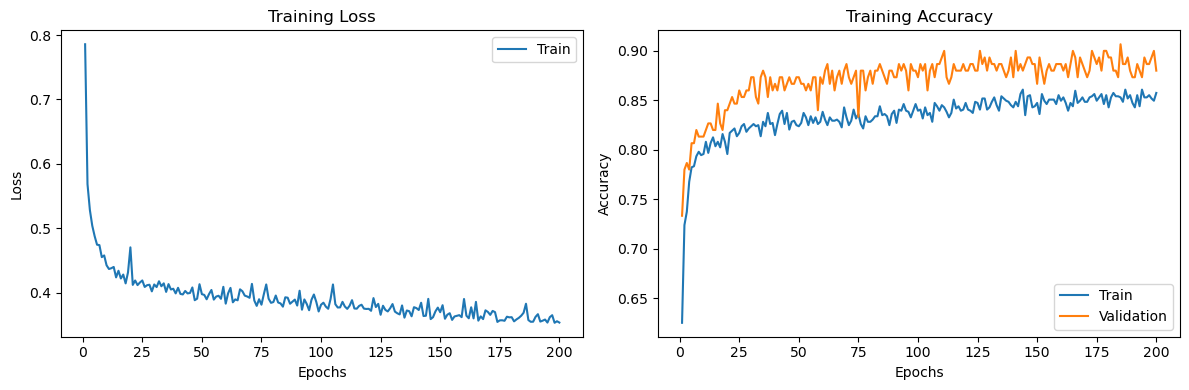

In [15]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
input_size = 25  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 2  # Number of output classes (yes, no)
learning_rate = 0.0005
num_epochs = 200


# Create an instance of the MLP model
model = MLP(input_size, hidden_size, output_size).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_accuracy_values = []

valid_accuracy_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.long)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    train_accuracy = correct / total
    print(f"Training Accuracy: {train_accuracy}")
    
    # Print the average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}")

    train_loss_values.append(average_loss)
    train_accuracy_values.append(train_accuracy)

    # Validation loop
    model.eval()
    correct = 0
    total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()



    # Calculate the accuracy on the validation set
    valid_accuracy = correct / total
    print(f"Validation Accuracy: {valid_accuracy}")

    valid_accuracy_values.append(valid_accuracy)

# Testing loop
model.eval()
correct = 0
total = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy on the test set
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label='Train')
plt.plot(epochs, valid_accuracy_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
test_data

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
891,3,34.500000,0,0,7.8292,0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
892,3,47.000000,1,0,7.0000,1,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
893,2,62.000000,0,0,9.6875,0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
894,3,27.000000,0,0,8.6625,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
895,3,22.000000,1,1,12.2875,2,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0.286678,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,1,39.000000,0,0,108.9000,0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,3,38.500000,0,0,7.2500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,3,0.286678,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
solutionDf = pd.read_csv("test.csv")
solutionDataset.data = solutionDataset.data.to(device)
solutions = model(solutionDataset.data)
_, predicted = torch.max(solutions.data, 1)

numpy_array = predicted.cpu().detach().numpy()
solutionDf["Survived"] = pd.Series(numpy_array, index=solutionDf.index)

solutionDf = solutionDf.drop(["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"],axis=1)
solutionDf.to_csv('output.csv', index=False)